next steps:
1. building attributes: json of building attributes - polymorphism
2. unit test this
3. encapsulation
4. come up with VAR for all properties

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from crrem.database import DataQ
import warnings
warnings.filterwarnings("ignore")

# impport raw data from database
target_level = DataQ("select * from crrem.target_levels").data
target_type = DataQ("select * from crrem.target_type").data
property_type = DataQ("select * from crrem.vw_epc_to_crrem_prop_type").data
country = DataQ("select * from crrem.country").data
country_factor = DataQ("select * from crrem.country_factor").data
currency = DataQ("select * from crrem.currency").data
emission_factor = DataQ("select * from crrem.emission_factors").data
energy_conversion_factor = DataQ("select * from crrem.energy_conversion_factor").data
energy_source = DataQ("select * from crrem.energy_source").data
price = DataQ("select * from crrem.price").data
price.set_index('year', inplace=True)
price['price'] = price['price'].astype(float)
scenario_gw = DataQ("select * from crrem.scenario_gw").data
zip_nuts = DataQ("select * from crrem.zip_to_nuts").data
zip_nuts.set_index('zip_code', inplace=True)
energy_use_type = DataQ("select * from crrem.energy_use_type").data
energy_use_breakdown = DataQ("select * from crrem.energy_use_breakdown").data
epc_main_fuel_mapping = DataQ("select * from crrem.epc_main_fuel_mapping").data
hdd_cdd_by_nuts = DataQ("select * from crrem.hdd_cdd_by_nuts").data
hdd_cdd_by_nuts.set_index('nuts_code', inplace=True)

In [68]:
json = {'BUILDING_REFERENCE_NUMBER':5336094578,'PROPERTY_GROUPING':'Domestic','PROPERTY_TYPE':'House',
       'POSTCODE': 'TS25 5HS','CO2_EMISS_CURR_PER_FLOOR_AREA': 66.0,'MAIN_FUEL':'mains gas (not community)',
       'ENERGY_CONSUMPTION_CURRENT':375,'TOTAL_FLOOR_AREA':101.0}

In [163]:
epc = DataQ(f"""select * from public.epcsourcedata where "BUILDING_REFERENCE_NUMBER" = {750222380000} """).data
epc = epc.set_index('BUILDING_REFERENCE_NUMBER')

In [80]:
epc['ENERGY_CONSUMPTION_CURRENT'].iloc[0] == None

True

In [164]:
epc

,PROPERTY_GROUPING,PROPERTY_TYPE,POSTCODE,CO2_EMISS_CURR_PER_FLOOR_AREA,MAIN_FUEL,ENERGY_CONSUMPTION_CURRENT,TOTAL_FLOOR_AREA,CO2_EMISS_CURR_PER_FLOOR_AREA_Median,ENERGY_CONSUMPTION_CURRENT_Median,NutsCode
BUILDING_REFERENCE_NUMBER,,,,,,,,,,
750222380000,Non-Domestic,C2 Residential Institutions - Universities and...,WC1E 6BP,47.43,Natural Gas,None,1391.0,50.68,280,UKI31


In [155]:
b.epc.loc[:,'ENERGY_CONSUMPTION_CURRENT']

BUILDING_REFERENCE_NUMBER
750222380000    280
Name: ENERGY_CONSUMPTION_CURRENT, dtype: object

In [156]:
class Building:
 
    def __init__(self, building_details, building_price):
        #add 7 EPC columns as property_details, in a json object
        if type(building_details) is int:
            epc = DataQ(f"""select * from public.epcsourcedata where "BUILDING_REFERENCE_NUMBER" = {building_details} """).data
            self.epc = epc.set_index('BUILDING_REFERENCE_NUMBER')
        elif type(building_details) is dict:
            #convert row of json to dataframe row
            self.epc = pd.DataFrame(data=building_details,index=[0]).set_index('BUILDING_REFERENCE_NUMBER')
            
        self.building_price = building_price
        self.stranding_year = None
        self.loss_vlaue = None


    def VAR(self, target_temp=1.5, RCP_scenario=4.5, discount_factor=0.02, end_year=2050, Diagram=True):
        # 1.Data preparation GHG emission target
        # find property type id
        property_type_id = property_type.loc[property_type['epc_prop_type'] == self.epc['PROPERTY_TYPE'].iloc[0]]['prop_use_type_id'].iloc[0]

        # specify target based on property type/target type/scenario
        years = list(range(2018,end_year+1))
        if target_temp == 1.5:
            gw_scenario_id = 1
        elif target_temp == 2.0:
            gw_scenario_id = 2
        emission_target = target_level[(target_level['prop_use_type_id']==property_type_id) & (target_level['target_type_id']==1) & (target_level['gw_scenario_id']==gw_scenario_id)]['target_level']
        emission_target = emission_target[:end_year-2018+1]
        emission_target.index = years
        energy_target = target_level[(target_level['prop_use_type_id']==property_type_id) & (target_level['target_type_id']==2) & (target_level['gw_scenario_id']==gw_scenario_id)]['target_level']
        energy_target = energy_target[:end_year-2018+1]
        energy_target.index = years

        # HDD/CDD projection
        # HDD - HDD index
        RCP = 'RCP' + str(RCP_scenario)

#         if self.epc['POSTCODE'].iloc[0] != 0:
#             NUTS3 = 'UK' + self.epc['POSTCODE'].iloc[0].split(' ')[0]

        years_index = list(range(3, 36))
        HDD = pd.DataFrame(columns=years_index, index=[1])
        for year in years_index:
            if RCP == 'RCP4.5':
                if len(self.epc['NutsCode']) > 1:
                    HDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp45_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']][
                                                            'hdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp45_pa'].iloc[0])
                else:
                    HDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp45_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp45_pa'].iloc[0])
            elif RCP == 'RCP8.5':
                if len(self.epc['NutsCode']) > 1:
                    HDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp85_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']][
                                                            'hdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp85_pa'].iloc[0])
                else:
                    HDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp85_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['hdd_rcp85_pa'].iloc[0])

        # assumption1: if one zip macthes multiple nuts, take the first nuts
        # CDD - CDD index
        CDD = pd.DataFrame(columns=years_index, index=[1])
        for year in years_index:
            if RCP == 'RCP4.5':
                if len(self.epc['NutsCode']) > 1:
                    CDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp45_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']][
                                                            'cdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp45_pa'].iloc[0])
                else:
                    CDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp45_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp45_pa'].iloc[0])
            else:
                if len(self.epc['NutsCode']) > 1:
                    CDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp85_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']][
                                                            'cdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp85_pa'].iloc[0])
                else:
                    CDD.iloc[0, year - 3] = (hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + year *
                                             hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp85_pa'].iloc[0]) / (
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_2015'].iloc[0] + 3 *
                                                        hdd_cdd_by_nuts.loc[self.epc['NutsCode']]['cdd_rcp85_pa'].iloc[0])
        CDD.columns = list(range(2018, 2051))
        HDD.columns = list(range(2018, 2051))
        HDD.fillna(0, inplace=True)
        CDD.fillna(0, inplace=True)
        HDD = HDD.iloc[:,:end_year-2018+1]
        CDD = CDD.iloc[:,:end_year-2018+1]

        # 2. GHG emission projection
        # emission data
        #impute missing data with median of property type
        if self.epc['CO2_EMISS_CURR_PER_FLOOR_AREA'].iloc[0] == None:
            current_emission = self.epc['CO2_EMISS_CURR_PER_FLOOR_AREA_Median'].iloc[0]
        else:
            current_emission = self.epc['CO2_EMISS_CURR_PER_FLOOR_AREA'].iloc[0]
        elec_heat = energy_use_breakdown['percentage'][0] / 100  # share of electricity for heating in UK
        elec_cool = energy_use_breakdown['percentage'][1] / 100
        fuel_heat = energy_use_breakdown['percentage'][2] / 100
        grid_uk = emission_factor['value']  # emission factor for UK

        # electricity usage share
        electricity_share = epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_elec'].iloc[0]

        emission = pd.Series(0, index=list(range(2018, 2051)))

        # assumption 2: district heating/cooling and fugitive emission not considered
        for year in years:
            if HDD.iloc[0, year - 2018] != 0:
                emission.iloc[year - 2018] = current_emission * (electricity_share * grid_uk[year - 2018] / grid_uk[0] * (
                            1 + elec_heat * (HDD.iloc[0, year - 2018] - 1) + elec_cool * (CDD.iloc[0, year - 2018] - 1)) + (
                                                                             (1 - electricity_share) * HDD.iloc[
                                                                         0, year - 2018] / HDD.iloc[0, 2018 - 2018] * (
                                                                                         1 + fuel_heat * (HDD.iloc[
                                                                                                              0, year - 2018] - 1))))
            if HDD.iloc[0, year - 2018] == 0:
                emission.iloc[year - 2018] = current_emission * (electricity_share * grid_uk[year - 2018] / grid_uk[0] * (
                            1 + elec_heat * (HDD.iloc[0, year - 2018] - 1) + elec_cool * (CDD.iloc[0, year - 2018] - 1)))
        emission = emission[:end_year-2018+1]
        
        emission_baseline = pd.Series(current_emission)
        emission_baseline = emission_baseline.repeat(len(emission.T))
        emission_baseline.index = years 
        emission_excess = emission - emission_target
        if len(emission_excess[emission_excess > 0]) == 0:
            emission_stranding_year = 2050
        else:
            emission_stranding_year = emission_excess[emission_excess > 0].index[0]

        # 3. energy projection
        # energy energy projection
        if self.epc['ENERGY_CONSUMPTION_CURRENT'].iloc[0] == None:
            current_energy = self.epc['ENERGY_CONSUMPTION_CURRENT_Median'].iloc[0]
        else:
            current_energy = self.epc['ENERGY_CONSUMPTION_CURRENT'].iloc[0]
        energy = pd.Series(0, index=list(range(2018, 2051)))
        for year in years:
            if HDD.iloc[0, year - 2018] != 0:
                energy.iloc[year - 2018] = current_energy * (electricity_share * grid_uk[year - 2018] / grid_uk[0] * (
                            1 + elec_heat * (HDD.iloc[0, year - 2018] - 1) + elec_cool * (CDD.iloc[0, year - 2018] - 1)) + (
                                                                         (1 - electricity_share) * HDD.iloc[
                                                                     0, year - 2018] / HDD.iloc[0, 2018 - 2018] * (
                                                                                     1 + fuel_heat * (
                                                                                         HDD.iloc[0, year - 2018] - 1))))
            if HDD.iloc[0, year - 2018] == 0:
                energy.iloc[year - 2018] = current_energy * (electricity_share * grid_uk[year - 2018] / grid_uk[0] * (
                            1 + elec_heat * (HDD.iloc[0, year - 2018] - 1) + elec_cool * (CDD.iloc[0, year - 2018] - 1)))
        energy = energy[:end_year-2018+1]

        energy_baseline = pd.Series(current_energy)
        energy_baseline = energy_baseline.repeat(len(energy.T))
        energy_baseline.index = years 
        energy_excess = energy - energy_target
        if len(energy_excess[energy_excess > 0]) == 0:
            energy_stranding_year = 2050
        else:
            energy_stranding_year = energy_excess[energy_excess > 0].index[0]

        # 4. energy costs
        elec_cost = price[price['source']=='elect_incl_vat']['price'][:end_year-2018+1] #electricity price incl. VAT
        gas_cost = price[price['source']=='gas_incl_vat']['price'][:end_year-2018+1] #gas price incl. VAT
        oil_cost = price[price['source']=='oil_incl_vat']['price'][:end_year-2018+1] #oil price incl. VAT
        wood_cost = price[price['source']=='wood_incl_vat']['price'][:end_year-2018+1] #wood pellets price incl. VAT
        coal_cost = price[price['source']=='coal_incl_vat']['price'][:end_year-2018+1] #coal price incl. VAT
        carbon_price = price[price['source']=='carbon']['price'][:end_year-2018+1] #carbon price incl. VAT
        total_energy = current_energy

        elec_cost = total_energy*elec_cost*epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_elec'].iloc[0]
        gas_cost = total_energy*gas_cost*epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_gas'].iloc[0]
        oil_cost = total_energy*oil_cost*epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_oil'].iloc[0]
        wood_cost = total_energy*wood_cost*epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_wood'].iloc[0]
        coal_cost = total_energy*coal_cost*epc_main_fuel_mapping.loc[epc_main_fuel_mapping['epc_main_fuel'] == self.epc['MAIN_FUEL'].iloc[0]]['weight_coal'].iloc[0]

        # 5. excess carbon costs and value at risk
        floor_area = self.epc['TOTAL_FLOOR_AREA'].iloc[0]
        total_emission = emission * floor_area
        total_target = emission_target * floor_area
        excess_cost = carbon_price * (total_emission - total_target)

        costs = pd.Series(np.nan, index=years)
        value = pd.Series(np.nan, index=years)
        for year in years:
            if excess_cost[year] < 0:
                costs[year] = 0
                value[year] = excess_cost[year]
            else:
                costs[year] = excess_cost[year]
                value[year] = 0

        discount_costs = costs.tolist().copy()
        discount_value = value.tolist().copy()

        for year in years:
            discount_costs[year - 2018] = discount_costs[year - 2018] / (1 + discount_factor) ** (year - 2018)
            discount_value[year - 2018] = discount_value[year - 2018] / (1 + discount_factor) ** (year - 2018)

        VAR = (sum(discount_costs) + sum(discount_value)) / self.building_price
        
        self.stranding_year = emission_stranding_year
        self.loss_value = sum(discount_costs) + sum(discount_value)
        #plot diagram
        if Diagram == True:
            years = list(range(2018,end_year+1))
            plt.figure(figsize = (20,10))
            plt.plot(emission_target, 'g', label = 'Decarbonisation emission_target')
            plt.plot(emission, 'k', label = 'Climate and grid corrected asset performance')
            plt.plot(emission_baseline, ':k', label = 'emission_baseline asset performance')
            plt.plot(emission_baseline.iloc[[0]],'kD', markersize = 10, label = '2018 performance') 

            #highlight stranding year
            stranding = emission_target - emission
            if (stranding<0).any():
                stranding_year = stranding[stranding < 0].index[0]
                plt.plot(emission[[stranding_year]], 'ro', markersize = 20, label = 'Stranding')

            #Excess emissions
            plt.fill_between(years, emission_target.tolist(), emission.tolist(), where = (emission_target < emission), color='C1', alpha=0.3, label = 'Excess emissions')
            plt.legend(loc = 'best', fontsize = 12)

            #set title and axis labels
            plt.title(f'Stranding Diagram(Asset #{self.epc.index.tolist()[0]})', fontsize = 25)
            plt.xlabel('Year', fontsize = 15)
            plt.ylabel('GHG intensity [kgCO2e/m²/a]', fontsize = 15)
            plt.show()
        
        return VAR

In [157]:
class Portfolio:

    def __init__(self, buildings):
        self.buildings = buildings
    
    def add_building(self, building):
        self.buildings.append(building)
        
    def VAR(self,target_temp=1.5, RCP_scenario=4.5, discount_factor=0.02, end_year=2050, Diagram=True):
        total_loss = 0
        total_price = 0
        years = list(range(2018,end_year+1))
        strand_buildings = pd.Series(0, index=years)
        for building in self.buildings:
            building.VAR(target_temp=target_temp, RCP_scenario=RCP_scenario, discount_factor=discount_factor, end_year=end_year, Diagram=False)
            total_loss += building.loss_value
            total_price += building.building_price
            if building.stranding_year < end_year:
                strand_buildings[building.stranding_year] += 1
        if Diagram == True:
            strand_buildings = strand_buildings.cummax()
            plt.figure(figsize = (20,10))
            plt.plot(strand_buildings, 'g', label = 'Decarbonisation emission_target')
            plt.title('Number of stranding assets over time', fontsize=25)
            plt.show()          
        return total_loss/total_price

In [165]:
a = Building(5336094578,500000)
b = Building(750222380000,500000)

json = {'BUILDING_REFERENCE_NUMBER':5336094578,'PROPERTY_GROUPING':'Domestic','PROPERTY_TYPE':'House',
        'CO2_EMISS_CURR_PER_FLOOR_AREA': 66.0,'MAIN_FUEL':'mains gas (not community)',
       'ENERGY_CONSUMPTION_CURRENT':375,'TOTAL_FLOOR_AREA':101.0,'NutsCode':'UKC11'}
c = Building(json,500000)
buildings = [c,b]

In [168]:
hdd_cdd_by_nuts.loc['UKI31']

nuts_year       2016.0
cdd_2015           0.0
cdd_rcp45_pa       0.0
cdd_rcp85_pa       0.0
hdd_2015           0.0
hdd_rcp45_pa       0.0
hdd_rcp85_pa       0.0
Name: UKI31, dtype: float64

In [174]:
b.VAR(Diagram=False,end_year=2050)

-0.030211422709852602

In [144]:
p = Portfolio(buildings)

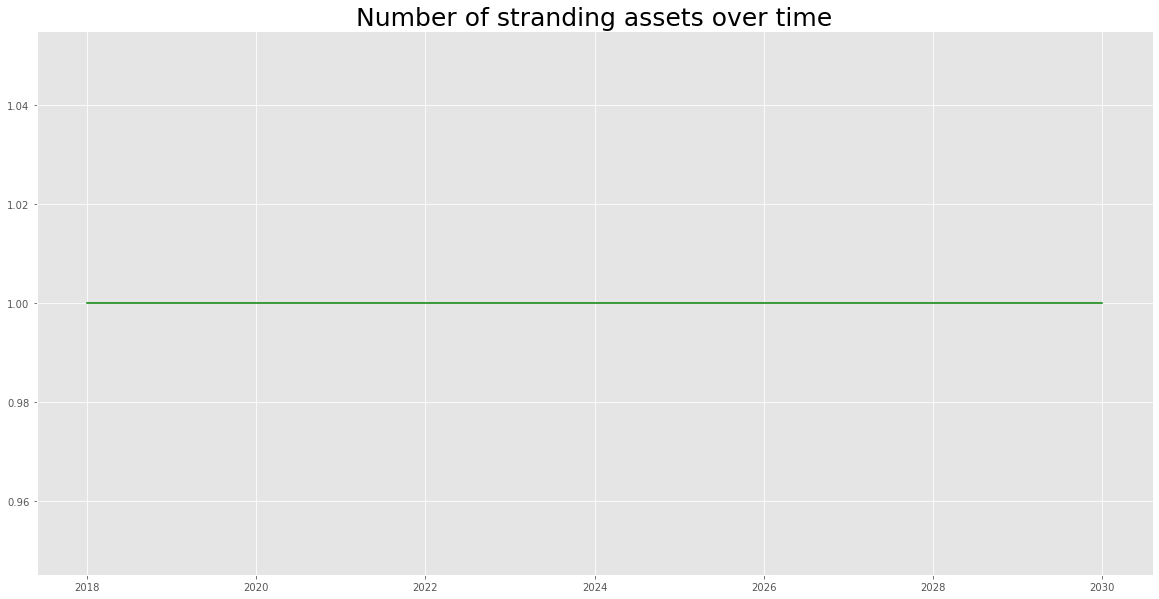

-0.00878260334211799

In [175]:
p.VAR(end_year=2030, Diagram=True)